# Neural Style Transfer
An implementation of neural style transfer for images as described in the paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et. al in 2015. We use a Convolutional Neural Network to transfer the style of one image onto another.

In [24]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import HTML, display
%matplotlib inline

`OUTPUT_DIR`: directory in which to save style-transferred image  
`STYLE_IMAGE`: image from which to transfer the style (we use Van Gogh's "Starry Night")  
`CONTENT_IMAGE`: image on which to transfer the style (we use a photo of the Vancouver skyline)

In [2]:
OUTPUT_DIR = 'output/'
STYLE_IMAGE = 'images/starry-night.jpg'
CONTENT_IMAGE = 'images/vancouver-skyline.jpg'

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
COLOR_CHANNELS = 3

In [26]:
display(HTML("<tr><td><img src='images/vancouver-skyline.jpg' width=150px>\
</td><td><img src='images/starry-night.jpg' width=150px></td></tr>"))

,


`NOISE_RATIO`: we create the style-transferred image by starting from white noise, and iteratively updating pixels until the content matches the content image, and the style image. It has been shown that starting from white noise over the content image results in faster performance than starting from pure white noise - here, the ratio is the proportion of our starting images which is composed of noise (the rest will be from the content image.  
  
`ALPHA`, `BETA`: these hyperparameters control how to balance trying to match the content of the content image, and the style of the style image. Specifically, these are the weights we assign to the content and style terms of the loss function respectively. A higher $\frac{\alpha}{\beta}$ results in an image that preserves more of the content, while a lower $\frac{\alpha}{\beta}$ results in an image much similar to the style image.  
  
`VGG_MODEL`: we use a pre-trained VGG-19 network to determine both the content and the style of an image. VGG-19 is a convolutional neural network architecture used for image classification, so the features it extracts to use for classification are a good representation of the content, and the correlations between these features represent the style of an image.

In [4]:
NOISE_RATIO = 0.6
BETA = 5
ALPHA = 100

VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

Helper function to load the pre-trained weights of the VGG-19 model. These (and many others) can be downloaded from [here](http://www.vlfeat.org/matconvnet/pretrained/).   
Although VGG-19 uses max-pooling, Gatys et. al found that using average pooling produces better results.

In [5]:
def load_vgg_model(path):
    """
    Load a pre-trained VGG-19 network from weights given in `path`.
    """
    
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer):
        W = vgg_layers[0][layer][0][0][0][0][0]
        b = vgg_layers[0][layer][0][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][-2]
        return W, b

    def _conv2d_relu(prev_layer, layer):
        W, b = _weights(layer)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.relu(tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b)

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']    = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    
    graph['conv1_1']  = _conv2d_relu(graph['input'],     0)
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'],   2)
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'],  5)
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'],   7)
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10)
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'],  12)
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'],  14)
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'],  16)
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19)
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'],  21)
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'],  23)
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'],  25)
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28)
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'],  30)
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'],  32)
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'],  34)
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [6]:
def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper by Gatys et. al
    """
    def _content_loss(l, x):
        N = l.shape[3]              # number of filters (at layer l)
        M = l.shape[1] * l.shape[2] # height times the width of the feature map (at layer l)
        return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - l, 2))
    
    return _content_loss(sess.run(model['conv4_2']), model['conv4_2'])

In [7]:
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

In [8]:
def style_loss_func(sess, model):
    """
    Style loss function as defined in the paper by Gatys et. al
    """
    def _gram_matrix(F, N, M):
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(l, x):
        N = l.shape[3]              # number of filters (at layer l)
        M = l.shape[1] * l.shape[2] # height times the width of the feature map (at layer l)
        
        A = _gram_matrix(l, N, M)   # style representation of the original image (at layer l)
        G = _gram_matrix(x, N, M)   # style representation of the generated image (at layer l)
        
        return (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

In [9]:
def generate_noise_image(content_image, noise_ratio=NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def load_image(path):
    image = scipy.misc.imread(path)
    image = np.reshape(image, ((1,) + image.shape)) # reshape to Tensor
    image = image - MEAN_VALUES                     # VGG expects image with mean subtracted
    return image

def save_image(path, image):
    image = image + MEAN_VALUES                     # add mean to reproduce original colours
    image = image[0]                                # reshape from Tensor to Matrix
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [10]:
sess = tf.InteractiveSession()

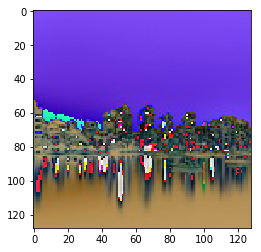

In [11]:
content_image = load_image(CONTENT_IMAGE)
plt.imshow(content_image[0])

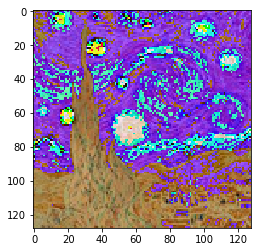

In [12]:
style_image = load_image(STYLE_IMAGE)
plt.imshow(style_image[0])

In [13]:
model = load_vgg_model(VGG_MODEL)

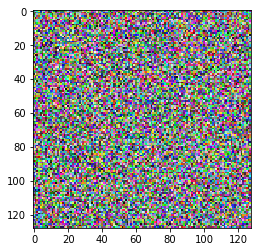

In [14]:
input_image = generate_noise_image(content_image)
plt.imshow(input_image[0])

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
sess.run(model['input'].assign(content_image))
content_loss = content_loss_func(sess, model)

In [17]:
sess.run(model['input'].assign(style_image))
style_loss = style_loss_func(sess, model)

In [18]:
total_loss = BETA * content_loss + ALPHA * style_loss

In [19]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

In [20]:
ITERATIONS = 10

In [21]:
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(input_image))

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%100 == 0:
        # Print every 100 iterations.
        mixed_image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
        print('cost: ', sess.run(total_loss))

        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (it)
        save_image(filename, mixed_image)

Iteration 0
sum :  -292779.0
cost:  3.1711e+11


In [22]:
save_image('output/art.jpg', mixed_image)

In [29]:
display(HTML("<tr><td><img src='output/art.jpg' width=150px></td></tr>"))

""
